## Importing Libraries

In [ ]:
import pandas as pd
import configparser
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import chi2_contingency

In [2]:
ENV = "C:/Users/knola/OneDrive/Documents/Projects/ThyroidCancerPred/project.env"
config = configparser.ConfigParser()
config.read(ENV)

['C:/Users/knola/OneDrive/Documents/Projects/ThyroidCancerPred/project.env']

In [3]:
# Iterate through sections and options
for section in config.sections():
    print(f"[{section}]")
    for option in config.options(section):
        value = config.get(section, option)
        print(f"{option} = {value}")

[PATHS]
entry = C:/Users/knola/OneDrive/Documents/Projects/ThyroidCancerPred


In [4]:
ENTRY = config['PATHS']['ENTRY']

In [5]:
raw = pd.read_csv(ENTRY+"/datasets/Thyroid_Diff.csv")

In [6]:
print(raw.columns)
print(raw.head(4))

Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')
   Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology   Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary  Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary  Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary  Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary  Uni-Focal  Low   

     T   N   M Stage    

# Dataset Explanation

**Hx Smoking**: History of Smoking

**Hx Radiotherapy**: History of Radiotherapy

**Thyroid Function**:
1) Euthyroid ~ normal function
2) Clinical Hyperthyroidism ~ thyroid problem
3) Subclinical Hyperthyroidism ~ lesser thyroid problem
4) Clinical Hypothyroidism ~ thyroid problem
5) Subclinical Hypothyroidism ~ lesser serious problem

**Physical Examination** ~ Refers to physical abnormatilies with the thyroid glands
1) Normal ~ normal
2) Everthing else ~ some form of problem

**Adenopathy**
1) No ~ No problem
2) Anything else ~ Complication

**Pathology** ~ The type of cancer

**Focaility**
1) Uni-Focal ~ detail about the cancer
2) Multi-Focal ~ this seems more serious problem with the cancer










<Axes: >

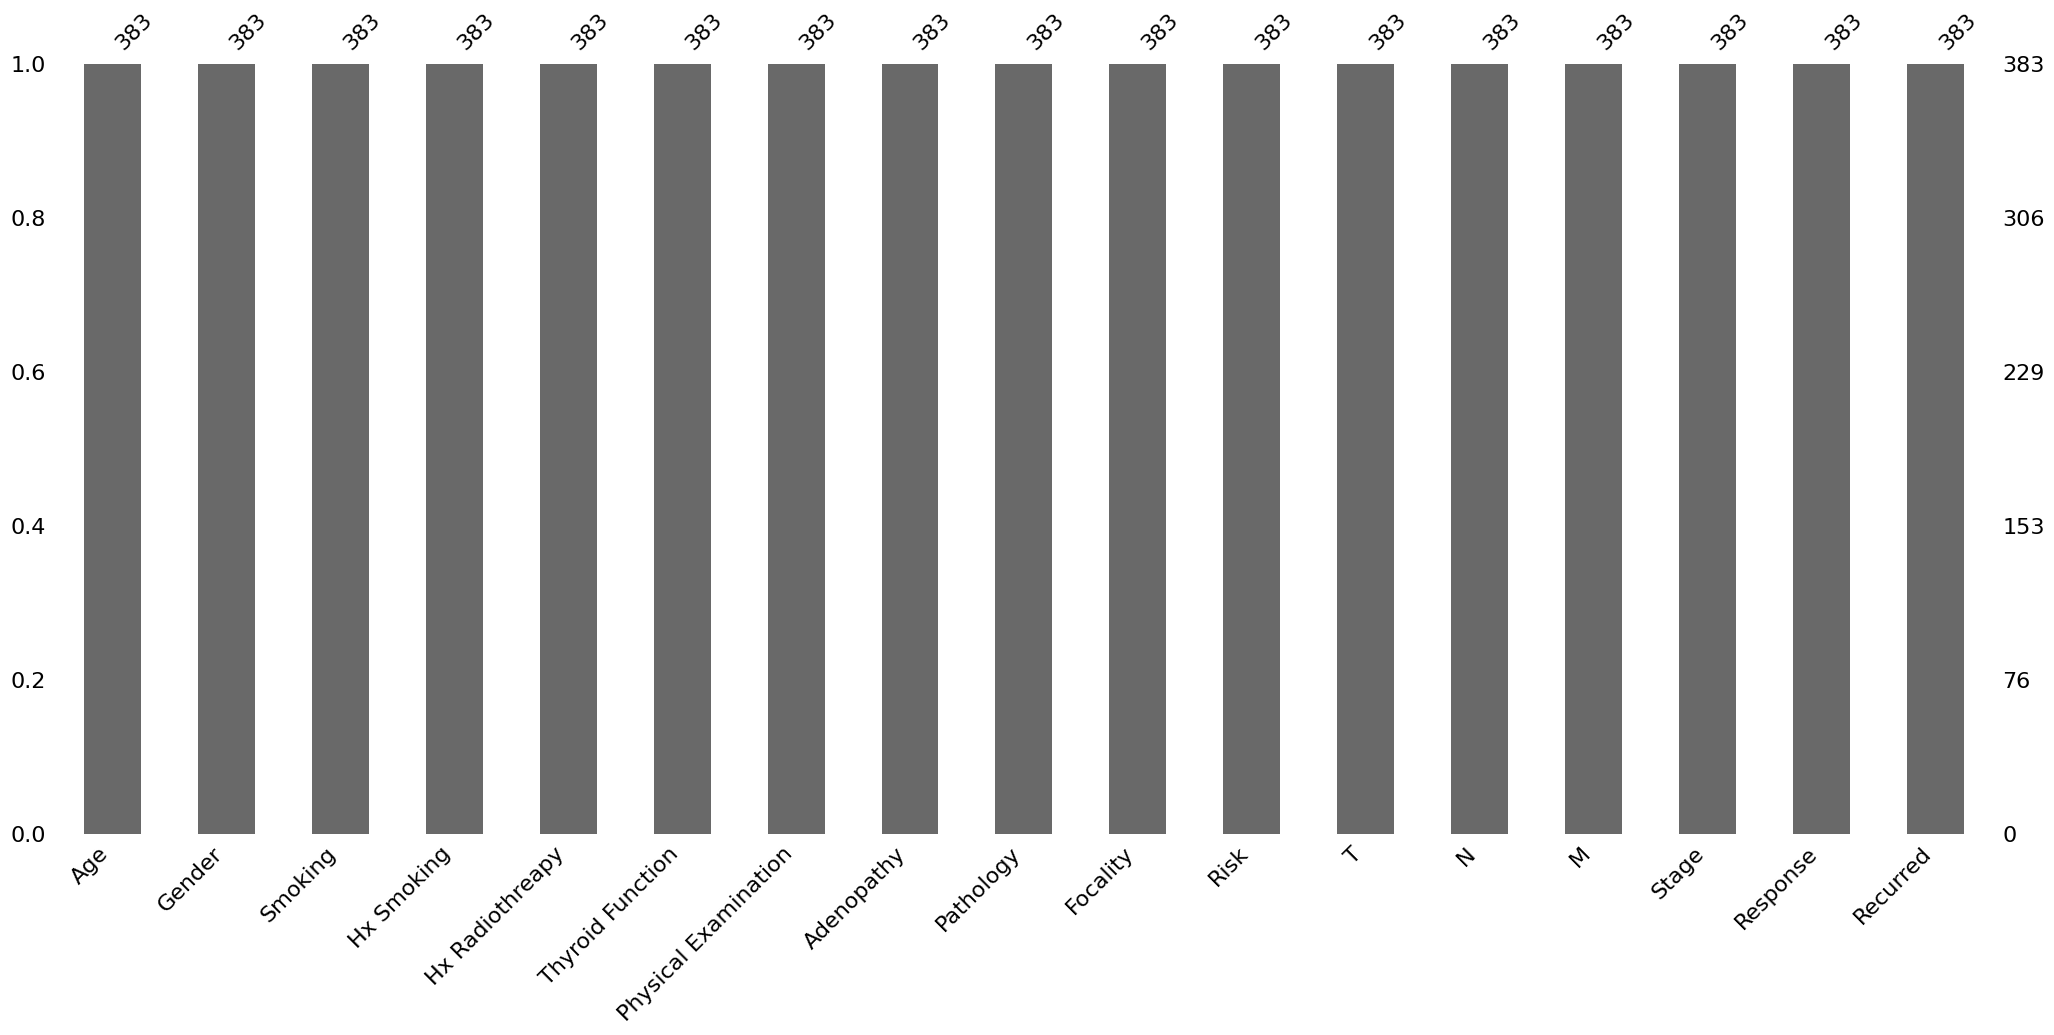

In [7]:
missingno.bar(raw)

There are no missing values in this dataset

array([[<Axes: title={'center': 'Age'}>]], dtype=object)

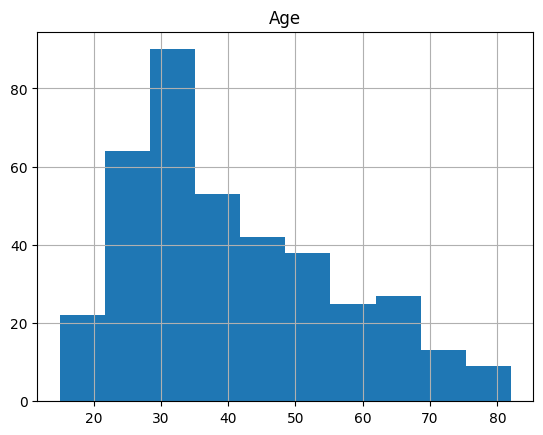

In [8]:
raw.hist()

Age is the only numeric feature, from this distribution we can see that the data is skewed heavily towards people in their 20s/30s.

Now to check for class imbalance in the target 

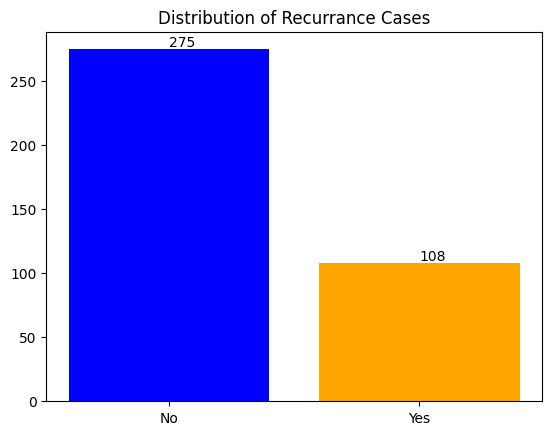

In [9]:
recurred_counts = raw["Recurred"].value_counts()
bar_colours = ['blue', 'orange']
recurred_bars = plt.bar(raw["Recurred"].unique(),recurred_counts, color=['blue', 'orange'])
plt.title('Distribution of Recurrance Cases')
for bar in recurred_bars:
  yval = bar.get_height()
  plt.text(bar.get_x()+bar.get_width()/2,yval,str(yval), va='bottom')

There exists class imbalance in this dataset. As we are dealing with medical data it is critical that we take into consideration the impact of false negatives.

In [10]:
raw

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,72,M,Yes,Yes,Yes,Euthyroid,Single nodular goiter-right,Right,Papillary,Uni-Focal,High,T4b,N1b,M1,IVB,Biochemical Incomplete,Yes
379,81,M,Yes,No,Yes,Euthyroid,Multinodular goiter,Extensive,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
380,72,M,Yes,Yes,No,Euthyroid,Multinodular goiter,Bilateral,Papillary,Multi-Focal,High,T4b,N1b,M1,IVB,Structural Incomplete,Yes
381,61,M,Yes,Yes,Yes,Clinical Hyperthyroidism,Multinodular goiter,Extensive,Hurthel cell,Multi-Focal,High,T4b,N1b,M0,IVA,Structural Incomplete,Yes


In [11]:
raw['Recurred'].iloc[0]

'No'

First example of 'Recurred' is no. This means that "no" will be encoded as 0 and "yes" will be encoded as 1.

## Correlation between Variables

We must check for the presence of correlated predictors in this dataset before building a model. Inclusion of highly correlated features in a prediciton model adds unneccessary complexity to the model and often leads to overfitting. As most of our data here is categorical, the chi square test for independence is the appropriate test for correlation. This unfortunately, will not tell us the degree of correlation between the features, rather just if they are correlated or not.

In [12]:
def isCorrelated(x, y, dataset=pd.DataFrame(), alpha=0.05):
  try:
    cross_tab = pd.crosstab(index=dataset[x], columns=dataset[y])
    chi2_res = chi2_contingency(cross_tab)
    p_val, is_corr = chi2_res[1], True if chi2_res[1] < alpha else False
  except Exception as e:
    print('The following exception has occurred:', e)
    return np.nan, False
  return p_val, is_corr

In [13]:
feature_comps = []
index = 1
all_features = raw.drop(columns=['Age']).columns.tolist()
for f1 in all_features:
  for f2 in all_features[index:]:
    feature_comps.append([f1,f2])
  index += 1

corr_mat = np.zeros(shape=[len(all_features),len(all_features)])
row = 0
column = 1
for pair in feature_comps:
  p_val, is_corr = isCorrelated(pair[0], pair[1], dataset=raw)
  corr_mat[row][column] = is_corr
  corr_mat[column][row] = is_corr
  if column == len(all_features)-1:
    row += 1
    column = row + 1
  else:
    column += 1

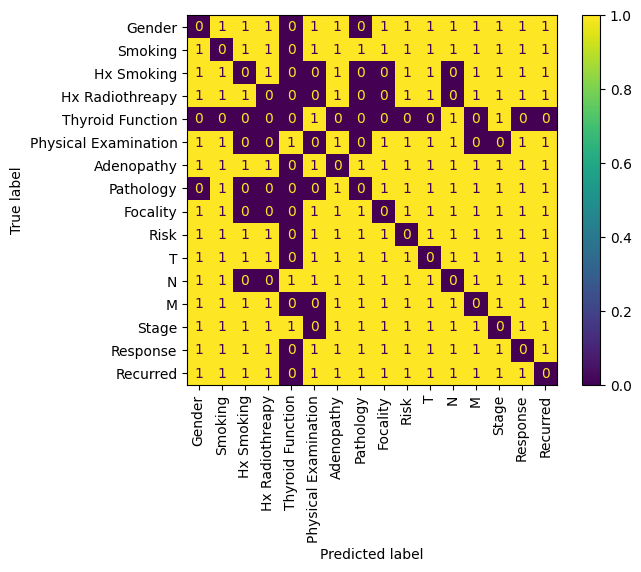

In [14]:
conf_mat = ConfusionMatrixDisplay(corr_mat, display_labels=all_features)
conf_mat.plot()
plt.xticks(rotation=90)
plt.show()

From this we can see that Thyroid function is not correlated with most predictors. Criticially it is also not correlated with our target 'Recurred', as such we should exclude this column in our models. Smoking, Risk, T and Stage are correlated with most of the features. We can use this information later in order to improve model performance.

In [15]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, n_features=2,n_pred_classes=2):
        self._n_features = n_features
        self._n_pred_classes = n_pred_classes
        super(SimpleNeuralNet, self).__init__()
        self._input_layer = nn.Linear(self._n_features, 64)
        self._hidden_layer = nn.Linear(64,self._n_features)
        self._output_layer = nn.Linear(self._n_features, 1)

    def forward(self, input):
        f1 = F.relu(self._input_layer(input))
        f2 = F.relu(self._hidden_layer(f1))
        output = F.sigmoid(self._output_layer(f2))
        return output

In [16]:
class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe=pd.DataFrame(), labels=["Recurred"]):
        self.data = dataframe
        self.labels = dataframe[labels].values.reshape(-1,1) 
        self.features = dataframe.drop(columns=labels).values  

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features = self.features[idx]
        label = self.labels[idx]
        return torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.float)

In [17]:
encoded_df = pd.get_dummies(raw.loc[:, ~raw.columns.isin(['Age', 'Recurred', 'Thyroid Function', 'Smoking', 'T', 'Risk', 'Stage'])], dtype=float) 
# I removed the column Thyroid Function here based on the correlation analysis above
encoded_df = pd.concat([encoded_df, raw[['Age', 'Recurred']]], axis=1)
encoded_df['Recurred'] = encoded_df['Recurred'].replace({'No':0, 'Yes':1})


In [18]:
y = encoded_df['Recurred']
x = encoded_df.drop(columns=['Recurred'])
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, shuffle=True, random_state=13, stratify=y)

In [19]:
print(y_train.value_counts()[1]/y_train.value_counts()[0])
print(y_test.value_counts()[1]/y_test.value_counts()[0])

0.39090909090909093
0.4


In [20]:
# Cross Validation Dataset Prep
rkf = RepeatedStratifiedKFold(n_splits=5,n_repeats=3,random_state=13)
n_splits = rkf.get_n_splits(x_train,y_train)

In [21]:
N_MODELS = 3
results_array = np.zeros(shape=(n_splits*N_MODELS, 3))

In [22]:
for i, (train_index, validation_index) in enumerate(rkf.split(x_train,y_train)):
  print(f"Current fold: {i}")
  # ====================================================== #
  # Data Prep
  # ====================================================== #
  cv_train = encoded_df.iloc[train_index].copy()
  cv_test = encoded_df.iloc[validation_index].copy()
  scaler = MinMaxScaler()
  cv_train[cv_train.drop(columns=['Recurred']).columns.to_list()] = scaler.fit_transform(cv_train.drop(columns=['Recurred']))
  cv_test[cv_train.drop(columns=['Recurred']).columns.to_list()] = scaler.transform(cv_test.drop(columns=['Recurred']))
  x_cv_train = cv_train.drop(columns=['Recurred'])
  y_cv_train = cv_train['Recurred']
  x_cv_test = cv_test.drop(columns=['Recurred'])
  y_cv_test = cv_test['Recurred']
  (num_neg, num_pos) = y_cv_train.value_counts()
  py_class_weight = torch.tensor([num_neg/num_pos])
  class_weights = compute_class_weight('balanced',classes=np.unique(y_cv_train.to_numpy()),y=y_cv_train.to_numpy())
  class_weights = {0:class_weights[0],1:class_weights[1]}
  # ====================================================== #
  # Neural Net
  # ====================================================== #
  net = SimpleNeuralNet(n_features=x.shape[1])
  loss_fn = nn.BCEWithLogitsLoss(pos_weight=py_class_weight)
  optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
  timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
  writer = SummaryWriter('../../datasets/tensorboard/nn_cv_{}_{}'.format(i,timestamp))
  torch_train = TorchDataset(cv_train)
  torch_val = TorchDataset(cv_test)
  torch_train_loader = torch.utils.data.DataLoader(torch_train,batch_size=16,shuffle=False)
  torch_val_loader = torch.utils.data.DataLoader(torch_val, batch_size=16, shuffle=False)
  best_vloss = float('inf')
  for epoch in range(40):
    running_loss = 0.
    last_loss = 0.
    net.train(True)
    for j, data in enumerate(torch_train_loader):
      inputs, labels = data
      labels = labels.view(-1, 1).float()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = loss_fn(outputs,labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (j+1) % 10 == 0:
        last_loss = running_loss/10
        # print('batch {} loss: {}'.format(j+1, last_loss))
        tb_x = (epoch+1) * len(torch_train_loader) + j + 1
        writer.add_scalar('Loss/train', last_loss, tb_x)
    net.eval()
    running_vloss = 0.
    with torch.no_grad():
      for k, vdata in enumerate(torch_val_loader):
        vinputs, vlabels = vdata
        voutputs = net(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss
    avg_vloss = running_vloss/(k+1)
    # print('LOSS train {} valid {}'.format(last_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : last_loss, 'Validation' : avg_vloss },
                    epoch + 1)
    writer.flush()
    if avg_vloss < best_vloss:
      best_vloss = avg_vloss
      model_path = '../../models/model_{}_best'.format(timestamp)
      torch.save(net.state_dict(), model_path)

  best_net = SimpleNeuralNet(n_features=x.shape[1])
  best_net.load_state_dict(torch.load(model_path))
  best_net.eval()
  with torch.no_grad():
    all_true_labels = []
    all_predictions = []
    for data in torch_val_loader:
        inputs, labels = data
        labels = labels.view(-1, 1).float()
        outputs = best_net(inputs)
        predicted = (outputs > 0.5).float()  # Apply threshold to get binary predictions
        all_true_labels.extend(labels.numpy().flatten())
        all_predictions.extend(predicted.numpy().flatten())
  conf_mat = confusion_matrix(all_true_labels, all_predictions)
  # This is just some code to view a single neural network's predictions as a confusion matrix
  # For anyone else playing with this code I recommend using a break or saving these plots somewhere if you need them.
  # conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
  # conf_mat_disp.plot()
  # plt.show()
  # break
  results_array[N_MODELS*i,0] = 0
  results_array[N_MODELS*i,1] = (conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])) # Specificity
  results_array[N_MODELS*i,2] = (conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0])) # Sensitivity
  # ====================================================== #
  # ====================================================== #
  # Random Forest #
  # ====================================================== # 
  rfc = RandomForestClassifier(class_weight=class_weights)
  rfc.fit(x_cv_train, y_cv_train)
  rfc_pred = rfc.predict(x_cv_test)
  conf_mat = confusion_matrix(y_cv_test.to_numpy().flatten(), rfc_pred)
  results_array[N_MODELS*i+1,0] = 1
  results_array[N_MODELS*i+1,1] = (conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])) # Specificity
  results_array[N_MODELS*i+1,2] = (conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0])) # Sensitivity
  conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
  # ====================================================== #
  # ====================================================== #
  # Logistic Regression #
  # ====================================================== #
  lgr = LogisticRegression(class_weight=class_weights)
  lgr.fit(x_cv_train, y_cv_train)
  lgr_pred = lgr.predict(x_cv_test)
  conf_mat = confusion_matrix(y_cv_test.to_numpy().flatten(), lgr_pred)
  results_array[N_MODELS*i+2,0] = 2
  results_array[N_MODELS*i+2,1] = (conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])) # Specificity
  results_array[N_MODELS*i+2,2] = (conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0])) # Sensitivity

Current fold: 0
Current fold: 1
Current fold: 2
Current fold: 3
Current fold: 4
Current fold: 5
Current fold: 6
Current fold: 7
Current fold: 8
Current fold: 9
Current fold: 10
Current fold: 11
Current fold: 12
Current fold: 13
Current fold: 14


In [23]:
results_df = pd.DataFrame(data=results_array,columns=['Model','Specificity', 'Sensitivity'])
results_df["Model"] = results_df['Model'].replace({0:'neural_net',1:'random_forest',2:'log_reg'})

for index, group in results_df.groupby(by=['Model']):
  print(group['Model'].iloc[0])
  avg_sen = np.average(group['Sensitivity'])
  avg_spec = np.average(group['Specificity'])
  print('Average Sensitivity: {}'.format(avg_sen))
  print('Average Specificty: {}\n'.format(avg_spec))
results_df.to_csv('../../datasets/results/CV Results.csv',encoding='utf-8',index=False)

log_reg
Average Sensitivity: 0.8779629629629631
Average Specificty: 0.9449885373666606

neural_net
Average Sensitivity: 0.8561111111111113
Average Specificty: 0.9850152514617924

random_forest
Average Sensitivity: 0.7885185185185187
Average Specificty: 0.9939080643927749



In [24]:
results_df = pd.DataFrame(data=results_array, columns=["model_name", "sensitivity", "specificity"])

In [25]:
results_df.head(6)

,model_name,sensitivity,specificity
0,0.0,1.000000,0.750000
1,1.0,0.982759,0.750000
2,2.0,0.982759,0.750000
3,0.0,1.000000,1.000000
4,1.0,1.000000,0.833333
5,2.0,0.909091,1.000000


([<matplotlib.axis.XTick at 0x27326c20510>,
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Neural Network'),
  Text(2, 0, 'Random Forest')])

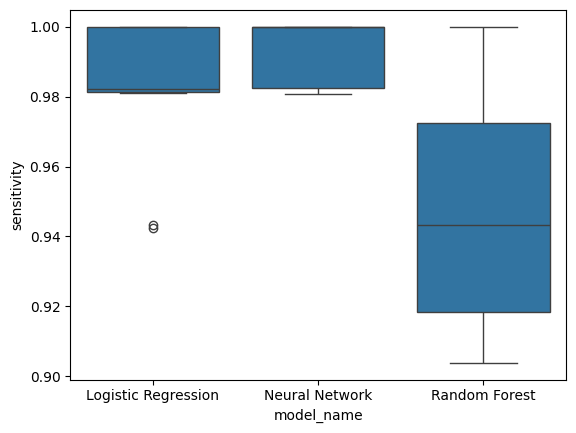

In [26]:
sns.boxplot(x='model_name', y='sensitivity', data=results_df[['model_name', 'sensitivity']])
plt.xticks([0,1,2], labels=['Logistic Regression', 'Neural Network', 'Random Forest'])

([<matplotlib.axis.XTick at 0x2733264ac50>,
 [Text(0, 0, 'Logistic Regression'),
  Text(1, 0, 'Neural Network'),
  Text(2, 0, 'Random Forest')])

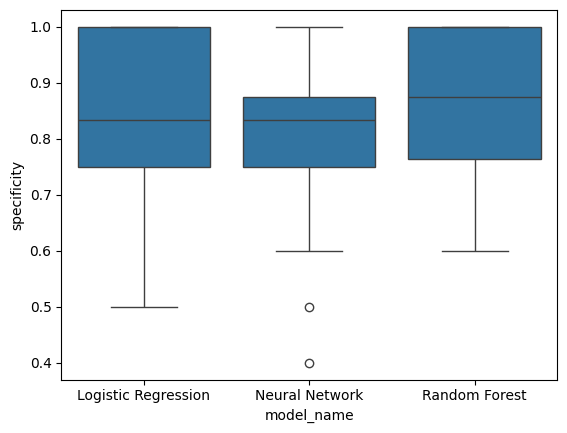

In [27]:
sns.boxplot(x='model_name', y='specificity', data=results_df[['model_name', 'specificity']])
plt.xticks([0,1,2], labels=['Logistic Regression', 'Neural Network', 'Random Forest'])

From this we can see that the neural network performs more consistently in the sensitivity test. As this is medical data we are more concerned with accurately predicting a positive result. As such, even this simple neural network is the clear winner in this instance.

## Final Model

Now that we have determined that the neural network is the best approach we should train the neural network on all of the training data to see if this would give a meaningful improvement over the cross-validated data.

In [28]:
(num_neg, num_pos) = y_train.value_counts()
py_class_weight = torch.tensor([num_neg/num_pos])
class_weights = compute_class_weight('balanced',classes=np.unique(y_train.to_numpy()),y=y_train.to_numpy())
class_weights = {0:class_weights[0],1:class_weights[1]}
final_results = np.zeros(shape=(1,2))
train_df = pd.concat((x_train, y_train), axis=1)
test_df = pd.concat((x_test,y_test), axis=1)
net = SimpleNeuralNet(n_features=x.shape[1])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=py_class_weight)
optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('../../datasets/tensorboard/nn_train_{}_{}'.format(i,timestamp))
torch_train = TorchDataset(train_df)
torch_val = TorchDataset(test_df)
torch_train_loader = torch.utils.data.DataLoader(torch_train,batch_size=16,shuffle=False)
torch_val_loader = torch.utils.data.DataLoader(torch_val, batch_size=16, shuffle=False)
best_vloss = float('inf')
for epoch in range(40):
  running_loss = 0.
  last_loss = 0.
  net.train(True)
  for j, data in enumerate(torch_train_loader):
    inputs, labels = data
    labels = labels.view(-1, 1).float()
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if (j+1) % 10 == 0:
      last_loss = running_loss/10
      # print('batch {} loss: {}'.format(j+1, last_loss))
      tb_x = (epoch+1) * len(torch_train_loader) + j + 1
      writer.add_scalar('Loss/train', last_loss, tb_x)
  net.eval()
  running_vloss = 0.
  with torch.no_grad():
    for k, vdata in enumerate(torch_val_loader):
      vinputs, vlabels = vdata
      voutputs = net(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss
  avg_vloss = running_vloss/(k+1)
  # print('LOSS train {} valid {}'.format(last_loss, avg_vloss))

  # Log the running loss averaged per batch
  # for both training and validation
  writer.add_scalars('Training vs. Validation Loss',
                  { 'Training' : last_loss, 'Validation' : avg_vloss },
                  epoch + 1)
  writer.flush()
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = '../../models/model_{}_best'.format(timestamp)
    torch.save(net.state_dict(), model_path)

best_net = SimpleNeuralNet(n_features=x.shape[1])
best_net.load_state_dict(torch.load(model_path))
best_net.eval()
with torch.no_grad():
  all_true_labels = []
  all_predictions = []
  for data in torch_val_loader:
      inputs, labels = data
      labels = labels.view(-1, 1).float()
      outputs = best_net(inputs)
      predicted = (outputs > 0.5).float()  # Apply threshold to get binary predictions
      all_true_labels.extend(labels.numpy().flatten())
      all_predictions.extend(predicted.numpy().flatten())
conf_mat = confusion_matrix(all_true_labels, all_predictions)
# This is just some code to view a single neural network's predictions as a confusion matrix
# For anyone else playing with this code I recommend using a break or saving these plots somewhere if you need them.
# conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
# conf_mat_disp.plot()
# plt.show()
# break
final_results[0,0] = (conf_mat[0][0]/(conf_mat[0][0]+conf_mat[0][1])) # Specificity
final_results[0,1] = (conf_mat[1][1]/(conf_mat[1][1]+conf_mat[1][0])) # Sensitivity

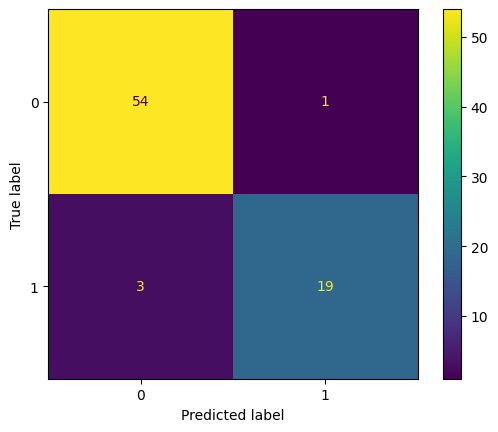

In [29]:
conf_mat_disp = ConfusionMatrixDisplay(conf_mat)
conf_mat_disp.plot()
plt.show()

In [30]:
report = classification_report(all_true_labels, all_predictions)
print(f'Classification Report:\n{report}\n')

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96        55
         1.0       0.95      0.86      0.90        22

    accuracy                           0.95        77
   macro avg       0.95      0.92      0.93        77
weighted avg       0.95      0.95      0.95        77




## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ../../datasets/tensorboard/

Using Tensorboard we see that there really isn't much of a performance gain with this model after 30 epochs. We could increase the model complexity to however model tuning and overall prediction performance isn't the goal of this notebook.  